# Example F11 DLM regression with DLMMC
**This notebook is based on the dlm_tutorial notebook provided with dlmmc https://github.com/justinalsing/dlmmc 
Here, we read in F11 data from ACE-FTS at 20.5 km and run the "vanilla" DLM model, which contains regressors for several common climate indices (ENSO, QBO, etc)**
## Import the required packages

In [22]:
# Import required modules
import pystan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy.interpolate as interpolate
import netCDF4
import pickle
import scipy.stats as stats
from utils.utils import *
from scipy.io.idl import readsav
%matplotlib inline

# Import the dlm model

**Note: make sure you have ran `compile_stan_models.py` before you do this!**

**There are a number of models to choose from: the standard model below `dlm_vanilla_ar1` has a non-linear trend, seasonal cycle with 6- and 12-month components with time-varying amplitude and phase, regressor (proxy) variables and an AR1 process. This is usually a good starting point. For specific model descriptions see `models/model_descriptions.pdf`**

In [23]:
# Import the DLM model
dlm_model = pickle.load(open('models/dlm_vanilla_ar1.pkl', 'rb'))

# Import your data

**In this example we import the BASIC stratospheric ozone composite [Ball et al 2017](https://www.research-collection.ethz.ch/handle/20.500.11850/202027) and pick out a single time-series to analyse as a demo.**

**You can load in your data however you like, but in the end you must have the following variables loaded into python:**

`d` np.array(N) *the data time-series*<br/>
`s` np.array(N) *std-deviation error-bars on each data point*

**Note: for missing data values, you should set those data NaNs and pass `d` and `s` into the function `prepare_missing_data()` (see below). This function just sets up the missing data values appropriately for the DLM code to understand: this function will just set the missing values to the mean of the rest of the data, but give them enormous error bars (1e20).** 

**Note: If you do not have measurement uncertainties available for your data, set `s` to be an array of small numbers (eg, 1e-20). The AR process will estimate the noise level on-the-fly, but note that you will then be assuming homoscedastic (but correlated) noise.**

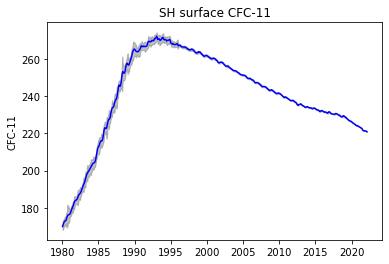

In [24]:
# Import data from a netCDF
data = readsav('data/GMD_F11.sav')

# The first element is F11 @ 60 S, 20.5 km
d = data['f11_nh']

# We don't really know, but we'll assume the error on the F11 data is 20%
s = data['f11_sd_nh']

N = len(d)

# The code for importing the regressors uses time in IDL's julian time, so here we create an IDL julian time array for the ACE-FTS data
pdtimeobj = pd.date_range('1980-01-15',periods=N,freq=pd.DateOffset(months=1))
timeobj = pdtimeobj.to_pydatetime()
T = np.array([i.toordinal()+1721424.5 for i in timeobj])   

# Sort out missing data if there is any: missing data should be NaNs (see notes above)
d, s = prepare_missing_data(d, s)

# Let's plot the data with uncertainties to check it looks OK

# Plot the selected data and error bars
plt.title('SH surface CFC-11')
plt.plot(timeobj, d, color = 'blue')
plt.fill_between(timeobj, d - s, d + s, color = 'grey', alpha = 0.5)
plt.ylabel('CFC-11')
plt.show()

## Import the regressors

**Here we import some standard regressors that are provided in the `regressors/` folder, but of course you can import your own regressors here as you please. In this example I import regressor data and interpolate on to the same time-grid as the imported data. For this example we import some standard indicies for: El Nino Southern Oscillation (ENSO), Solar activity (Solar), the Quasi-Biennial Oscillation (QBO; two indicies QBO30 and QBO50) and stratospheric aerosol optical depth (SAOD) for volcanic eruptions.**

**Again you can import the regressors however you like, but the result must be the following variable loaded into python:**

`regressors` np.array(N, nreg) *2d array with each column representing one regressor (evaluated on the same time-grid as your data)*

**Note: Missing values/NaNs in the regressors are not currently supported, please interpolate missing values so that they are all real valued. It is also good practice to normalize your regressors to be zero mean and have a range [-0.5, 0.5], so they are all on the same scale. Having regressors with wildly different scales can cause issues.**

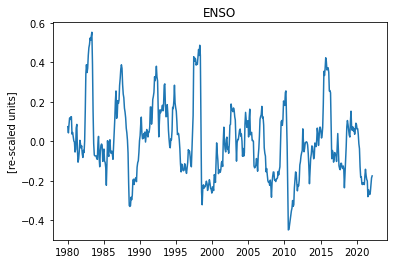

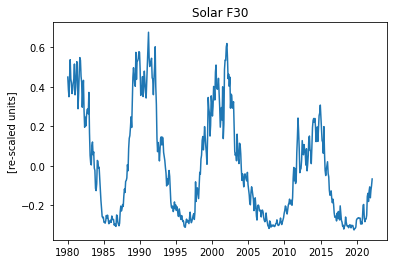

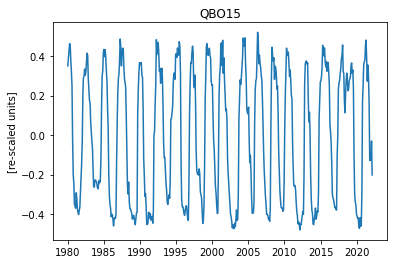

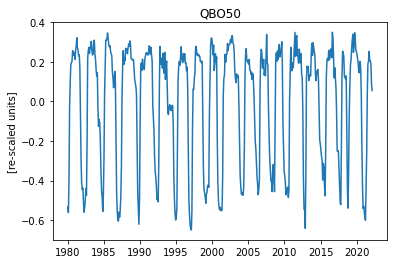

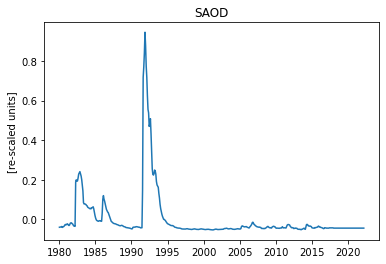

In [25]:
# Import the regressors

# ENSO - 
mei=np.loadtxt('regressors/ENSO_MEI_ENSO_197901_202203.dat')
y = mei[:,1]
t = mei[:,0]
Y = interpolate.InterpolatedUnivariateSpline(t, y,ext=3)
enso = Y(T) # This extacts the regressor at the times you have in your dataset, interpolated in case the time grid is different
enso = (enso - enso.mean()) / (enso.max()-enso.min())    
                               
# Solar -- unclear exactly where this solar data came from so for the time being we are 
regressor = np.loadtxt('regressors/Flux_F30_monthly_195111_202205_absolute.txt')
t=regressor[:,0]
y=regressor[:,1]
Y = interpolate.InterpolatedUnivariateSpline(t, y, ext=3)
solar = Y(T)
solar = (solar - solar.mean()) / (solar.max() - solar.min())

# QBO30
regressor = np.loadtxt('regressors/singapore_50hpa_30hpa_15hpa_1953-2021.txt')
t=regressor[:,0]
y=regressor[:,2]
Y = interpolate.InterpolatedUnivariateSpline(t, y,ext=3)
qbo30 = Y(T-365.) 
qbo30 = (qbo30 - qbo30.mean()) / (qbo30.max() - qbo30.min())

# QBO50
y=regressor[:,1]
Y = interpolate.InterpolatedUnivariateSpline(t, y,ext=3)
qbo50 = Y(T-850.) # This extacts the regressor at the times you have in your dataset, interpolated in case the time grid is different
qbo50 = (qbo50 - qbo50.mean()) / (qbo50.max() - qbo50.min())

# QBO15
y=regressor[:,3]
Y = interpolate.InterpolatedUnivariateSpline(t, y,ext=3)
qbo15 = Y(T-850.) # This extacts the regressor at the times you have in your dataset, interpolated in case the time grid is different
qbo15 = (qbo15 - qbo15.mean()) / (qbo15.max() - qbo15.min())


# SAOD
saod_data = netCDF4.Dataset('regressors/sad_1979_2017_10deg_60S_60N_missNans.nc')
# # a latitude-dependent version of the SAOD is used for the DLM, so this is added to the regressors inside the loop that creates the data to feed into the DLM
y = saod_data['saod_strat_column'][:, 6]
t = saod_data['time'][:]
Y = interpolate.InterpolatedUnivariateSpline(t, y,ext=3)
saod = Y(T)
saod = (saod - saod.mean()) / (saod.max() - saod.min())

# Stack the regressors into big 2d array
regressors = np.column_stack([enso, solar, qbo15, qbo50,saod]) # Stack of all the regressors together in a 2d array

# Plot all the regressors to check they look OK
plt.plot(timeobj, enso)
plt.title('ENSO')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(timeobj, solar)
plt.title('Solar F30')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(timeobj, qbo15)
plt.title('QBO15')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(timeobj, qbo50)
plt.title('QBO50')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(timeobj, saod)
plt.title('SAOD')
plt.ylabel('[re-scaled units]')
plt.show()

## Set the data and initialization to be fed into the dlm

### `input_data`

**First we set the `input_data` - a dictionary of all the data and input parameters than the dlm model requires in order to run. The input data must have the following entries:**

`time_series` np.array(N) *data vector (time-series to be analyzed)*<br/>
`stddev` np.array(N) *standard deviation error bars for the time-series*<br/>
`N` (int) *number of time-steps in the time-series ie., length of your data vector*<br/>
`nreg` (int) *number of regressors*<br/>
`regressors` np.array(N, nreg) *the regressors: 2D array of size (data vector length, number of regressors)*<br/>
`sampling` (float) *sampling rate of the data: specify "daily", "monthly" or "annual" to the function sampling()*<br/>
`S` (float) *variance of the Gaussian prior on the regression coefficients; set to 10 as default*<br/>
`sigma_trend_prior` (float) *standard deviation of the half-Gaussian prior on* `sigma_trend` *that controls how wiggly the trend can be; set to 1e-4 as default*<br/>
`sigma_seas_prior` (float) *standard deviation of the half-Gaussian prior on* `sigma_seas`, *controls how dynamic the seaonal cycle can be; set to 0.01 as default*<br/>
`sigma_AR_prior` (float) *standard deviation of the half_Gaussian prior on the AR1 process's standard deviation; set to 0.5 as default*<br/>
`sigma_reg_prior` np.array(nreg) *standard deviation of the half_Gaussian prior on* `sigma_reg` *parameters, controling how dynamic the regressor amplitudes can be (in time); set to 1e-4 for all as default*

**Note: You should leave out parameters that are not included in your model, eg, if you are running a model without dynamical regressors you can leave out `sigma_reg_prior`, or if you are running a model without regressors you can leave out `regressors`. See Table 1 of `models/model_descriptions.pdf` for details of which parameters are included for which models.**

**Units: Note that the std-deviation hyper-parameters (`sigma_trend`, `sigma_seas`, `sigma_AR` and `sigma_reg`) controlling how dynamic various components of the DLM model are, are defined in units of the range of the input data, ie, / (max(time_series) - min(time_series)). In this sense they define fractional standard-deviations wrt the data. This provides a common ground for defining priors on the dynamics hyper-parameters irrespective of the units of the data.**

### `initial_state`

**Second, we set the `initial_state` - a dictionary of initial guesses for the hyper-parameters for initializing the MCMC sampler. This must have the following entries (with sugegsted default values):**

`sigma_trend` (float) *initial value for* `sigma_trend`; *default to 0.0001*<br/>
`sigma_seas` (float) *initial value for* `sigma_seas`; *default to 0.001*<br/>
`sigma_AR` (float) *initial value for* `sigma_AR`; *default to 0.01*<br/>
`rhoAR1` (float) *initial value for* `rhoAR1`; *default to 0.1*<br/>
`rhoAR2` (float) *initial value for* `rhoAR2`; *default to 0*<br/>
`sigma_reg` np.array(nreg) *initial value for* `sigma_reg`; *default to 1e-4 for all*

**Note: Again, you can leave out parameters that are not included in your model, ie if you are running one of the AR1 models you do not need `rhoAR2`, and if you are running models without dynamical regressors you can leave out `sigma_reg`. See `models/model_descriptions.pdf` (Table 1) for details of which parameters are included for which models.**

In [26]:
# Set the data and initialization of parameters that are fed into the DLM

# Input data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
input_data = {
                    'time_series':d, # float[N] data vector
                    'stddev':s, # float[N] std-dev error bars
                    'N':len(d), # (int) number of time-steps in the time-series
                    'nreg':len(regressors.T), # (int) number of regressors
                    'regressors':regressors, # float[N, nreg] the regressors
                    'sampling':sampling_rate("monthly"), # must be "daily", "monthly", or "annual"
                    'S':10., # prior variance on the regression coefficients
                    'sigma_trend_prior':1e-4, # std-dev of the half-Gaussian prior on sigma_trend
                    'sigma_seas_prior':0.01, # std-dev of the half-Gaussian prior on sigma_seas
                    'sigma_AR_prior':0.5 # std-dev of the half_Gaussian prior on the AR1 process std-dev 
                }

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':1e-4,
                 'sigma_seas':1e-3,
                 'sigma_AR':1e-2,
                 'rhoAR1':0.1,
                }

## OK let's run the DLM!

**Now we're set up we can run the dlm. Below we run an HMC sampler (using `pystan`) together with Kalman filtering (and smoothing) steps to obtain samples from the joint posterior of the dlm model parameters given the input data and uncertainties, ie.,**

$P(nonlinear\;trend,\,seasonal\;cycle,\,AR\;process,\,regressor\;coefficients,\,hyperparameters | data)$

**The input parameters to the function `sampling()` below have the following meanings:**

`data` = *input data dictionary from above*<br/>
`iter` = *total number of MCMC samples to get; should be at least a few thousand*<br/>
`warmup` = *how many evaluations are allowed for the HMC sampler to "warm-up" (these are discarded in the final output)*<br/>
`chains` = *how many parallel chains to run? (see below for running parallel chains)*<br/>
`init` = *list of initial state dictionaries (from above), one per chain*<br/>
`pars` = *which parameters do you actually want to save as output in the results? (see below)*

**The `pars` parameter controls which parameters you want to save in the output results. You can choose any number from the following:**

`sigma_trend` (float) *hyper-parameter controlling how wiggly the trend can be*<br/>
`sigma_seas` (float) *hyper-parameter controlling how dynamic the seasonal cycle can be*<br/>
`sigma_AR` (float) *standard deviation parameter for the AR process*<br/>
`rhoAR1` (float) *first correlation parameter for the AR process*<br/>
`rhoAR2` (float) *second correlation parameter for the AR process*<br/>
`sigma_reg` np.array(nreg) *hyper-parameter controlling how dynamic the regressor amplitudes can be*<br/>
`beta` np.array(nreg, N) *dynamical regression coefficients*<br/>
`trend` np.array(N) *non-inear DLM trend (as function of time)*<br/> 
`slope` np.array(N) *slope of the non-linear DLM trend (as function of time)*<br/>
`seasonal` np.array(N) *seasonal cycle with 6- and 12- month components (as function of time)*<br/>
`ar` np.array(N) *fitted AR process (as function of time)*

**Note: you can only inlcude things in `pars` that are actually included in the model you are running. See Table 1 of `models/model_descriptions.pdf` for which parameters are available in each of the models.**

**NOTE: you should limit your output `pars` to things you really want to look at after to keep the output smaller - it will be faster to work with for making plots etc later on, and take up less memory. If you do not set pars it will automatically save everything by default.**

**Running multiple chains in parallel: It is easy to run multiple chains in parallel by simply setting `chains` > 1. If you do this you must also provide a list of initial state dictionaries to `init`, ie., `init` = [initial_state1, initial_state2, ...] (precicely one initial state per chain, and they need not be different although it is good practice to give the chains different starting points)**

**OK let's do it! NB it will take a few minutes to run so be patient**

In [27]:
# Ok, let's run it
fit = dlm_model.sampling(data=input_data, iter=2000, warmup=1000, chains=1, init = [initial_state], verbose=True, pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'rhoAR1', 'trend', 'slope', 'beta', 'seasonal','ar'))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)



Gradient evaluation took 0.028466 seconds
1000 transitions using 10 leapfrog steps per transition would take 284.66 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 / 2000 [ 20%]  (Warmup)
Iteration:  600 / 2000 [ 30%]  (Warmup)
Iteration:  800 / 2000 [ 40%]  (Warmup)
Iteration: 1000 / 2000 [ 50%]  (Warmup)
Iteration: 1001 / 2000 [ 50%]  (Sampling)
Iteration: 1200 / 2000 [ 60%]  (Sampling)
Iteration: 1400 / 2000 [ 70%]  (Sampling)
Iteration: 1600 / 2000 [ 80%]  (Sampling)
Iteration: 1800 / 2000 [ 90%]  (Sampling)
Iteration: 2000 / 2000 [100%]  (Sampling)

 Elapsed Time: 228.698 seconds (Warm-up)
               207.55 seconds (Sampling)
               436.248 seconds (Total)



## Extract the results

**By this point, the `fit` object contains "n_samples = (iter - warmup) x chains" samples of each of the parameters in "pars" that you chose to output. To access the samples for any individual parameter, just do:**

parameter_samples = fit.extract()['insert parameter name here'] (see examples below)

**For example, if you do `fit.extract()['trend']` it will give an array `np.array(n_samples, N)`, n_samples
samples of the full DLM trend, which has lengh N.**

**All outputs from the fit object will have shape n_samples x dimension of variable (see above).**

**To make life easier for anlysing the results in the rest of the notebook, let's extract all the samples here in one go...**


In [28]:
# Extract the various bits from the fit-object. 

# Trend
trend = fit.extract()['trend'][:,:]

# Gradient of the DLM trend
slope = fit.extract()['slope'][:,:]

# Seasonal cycle
seasonal_cycle = fit.extract()['seasonal'][:,:]

# Regressor coefficients
regressor_coefficients = fit.extract()['beta'][:,:]

# AR timeseries
ar = fit.extract()['ar'][:,:]

# DLM hyper parameters
sigma_trend = fit.extract()['sigma_trend']
sigma_seas = fit.extract()['sigma_seas']
sigma_AR = fit.extract()['sigma_AR']
rhoAR1 = fit.extract()['rhoAR1']

## Finally, let's make some plots of the outputs!

**Obviously we can compute and plot whatever we like now we have the results, but let's make a few example plots of the various parameters we have inferred to showcase the results.**

### Let's start by plotting the recovered dlm trend and corresponding (1$\sigma$) uncertainties:

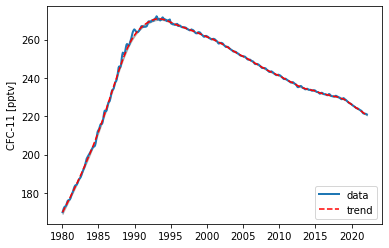

In [29]:
# Plot recovered trend against the data

# Plot the data
plt.plot(timeobj, d, lw = 2,  label='data')

# Plot the mean trend
plt.plot(timeobj, np.mean(trend, axis = 0), color = 'red', ls = '--', label='trend')
plt.legend(loc='lower right')

# Plot a grey band showing the error on the extracted DLM trend
# NOTE: this includes the error on the shape of the trend, but also on the overall offset, so can look deceptively large
plt.fill_between(timeobj, np.mean(trend, axis = 0) - np.std(trend, axis = 0), np.mean(trend, axis = 0) + np.std(trend, axis = 0), color = 'grey', alpha = 0.5)
plt.ylabel('CFC-11 [pptv]')
plt.show()

### We can also plot the recovered slope of the trend (i.e., growth rate!) as a function of time:

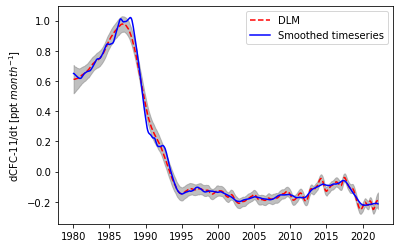

In [30]:
# Plot the slope of the recovered trend

plt.plot(timeobj, np.mean(slope, axis = 0), color = 'red', ls = '--',label='DLM')
plt.fill_between(timeobj, np.mean(slope, axis = 0) - np.std(slope, axis = 0), np.mean(slope, axis = 0) + np.std(slope, axis = 0), color = 'grey', alpha = 0.5)
plt.ylabel('dCFC-11/dt [ppt $month^{-1}$]')

plt.plot(timeobj, np.gradient(data['f11_nh_sm']), color='blue', label='Smoothed timeseries')
plt.legend(loc='upper right')
plt.show()

### Now for the recovered seasonal cycle - note that modulation in the amplitude of the seasonal cycle is allowed in the dlm model (but here is not strongly preferred by the data):

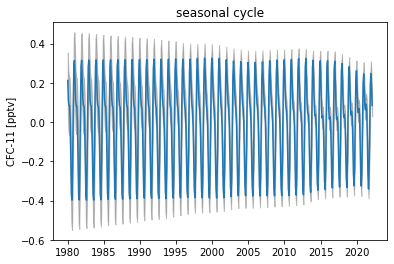

(1000, 506)

In [31]:
# Plot the recovered seasonal cycle and uncertainties
plt.plot(timeobj, np.mean(seasonal_cycle, axis = 0))
plt.fill_between(timeobj, np.mean(seasonal_cycle, axis = 0) - np.std(seasonal_cycle, axis = 0), np.mean(seasonal_cycle, axis = 0) + np.std(seasonal_cycle, axis = 0), color = 'grey', alpha = 0.5)
plt.title('seasonal cycle')
plt.ylabel('CFC-11 [pptv]')
plt.show()
np.shape(seasonal_cycle)

### Now plot the data with various versions of the fit on overlaid

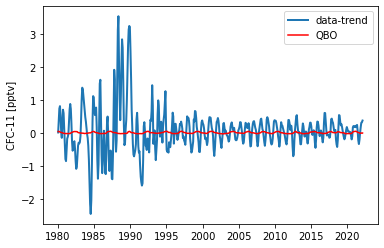

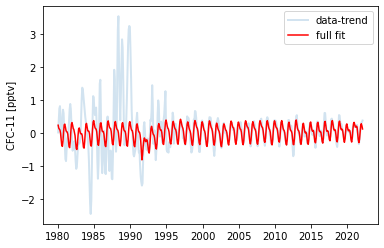

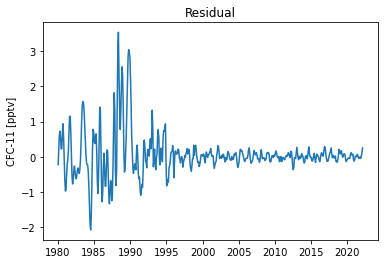

In [32]:
# Plot the data
trendts = trend.mean(axis=0)
plt.plot(timeobj, d-trendts, lw = 2, label='data-trend')

#reconstructed qbo timeseries
qbots = regressors[:,2]*np.mean(regressor_coefficients[:,2],axis=0) + regressors[:,3]*np.mean(regressor_coefficients[:,3],axis=0)

#reconstructed timeseries from all regressors
allts = qbots + regressors[:,0]*np.mean(regressor_coefficients[:,0],axis=0) + regressors[:,1]*np.mean(regressor_coefficients[:,1],axis=0) + regressors[:,4]*np.mean(regressor_coefficients[:,4],axis=0)
seasonalts = seasonal_cycle.mean(axis=0)

# overplot the mean trend + seasonal cycle + QBO
plt.plot(timeobj, qbots, color = 'red', label='QBO')
plt.ylabel('CFC-11 [pptv]')
plt.legend(loc='upper right')
plt.show()

# overplot the seasonal cycle + ENSO/SOLAR/QBO/SAOD + AR
plt.plot(timeobj, d-trendts, lw = 2, alpha = 0.2, label='data-trend')
plt.plot(timeobj, seasonal_cycle.mean(axis=0)+allts + np.mean(ar,axis=0), color = 'red', label='full fit')
plt.ylabel('CFC-11 [pptv]')
plt.legend(loc='upper right')
plt.show()

# overplot the residual
plt.plot(timeobj, d-(trendts+seasonal_cycle.mean(axis=0)+allts + np.mean(ar,axis=0)) )
plt.ylabel('CFC-11 [pptv]')
plt.title('Residual')
plt.show()

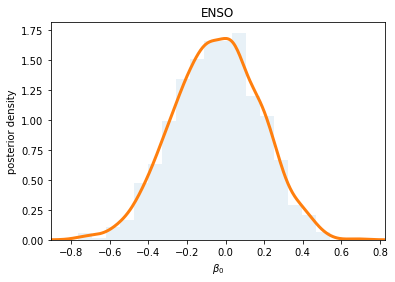

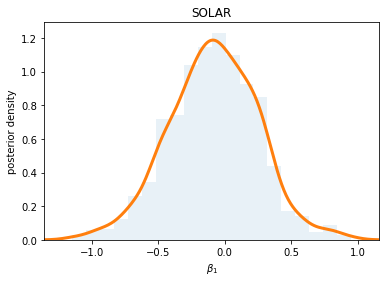

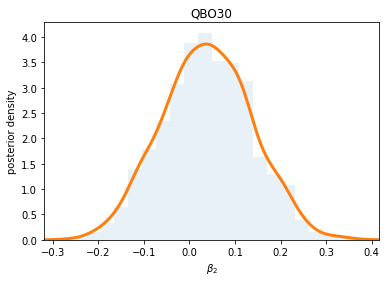

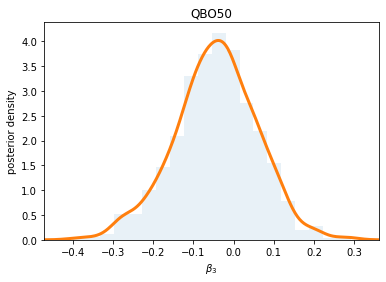

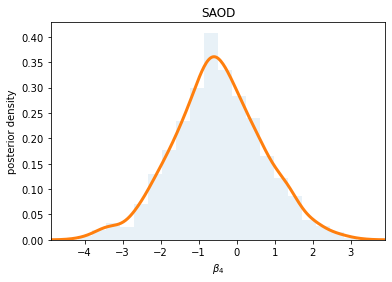

In [33]:
# Plot posteriors for the regression coefficients
regressor_names = ['ENSO', 'SOLAR', 'QBO30', 'QBO50', 'SAOD']
for i in range(len(regressors.T)):
    beta = regressor_coefficients[:,i]
    kde = stats.gaussian_kde(beta)
    x = np.linspace(min(beta) - np.ptp(beta)*0.1, max(beta) + np.ptp(beta)*0.1, 300)
    plt.hist(beta, bins=20, density=True, alpha = 0.1)
    plt.plot(x, kde(x), lw = 3)
    plt.xlim(x[0], x[-1])
    plt.title(regressor_names[i])
    plt.ylabel('posterior density')
    plt.xlabel(r'$\beta_{}$'.format(i))
    plt.show()

### We can also plot histograms of the dlm hyper-parameter posteriors:

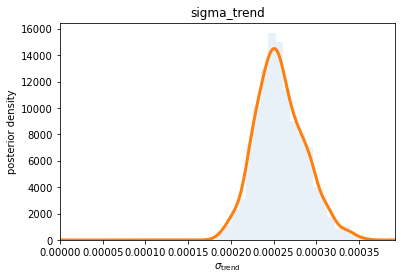

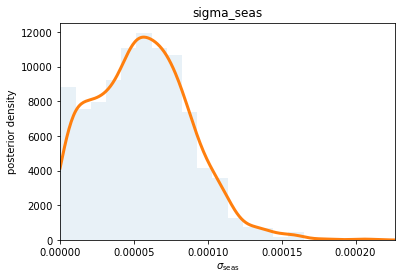

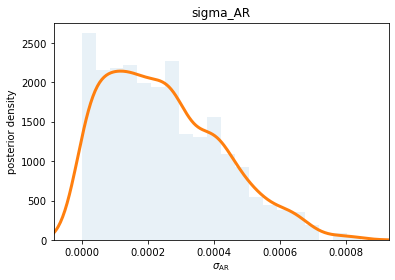

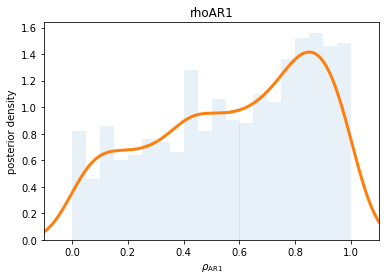

In [34]:
# Plot posteriors for the DLM hyper parameters
kde = stats.gaussian_kde(sigma_trend)
x = np.linspace(0, max(sigma_trend)*1.1, 300)
plt.hist(sigma_trend, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.show()

kde = stats.gaussian_kde(sigma_seas)
x = np.linspace(0, max(sigma_seas)*1.1, 300)
plt.hist(sigma_seas, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.show()

kde = stats.gaussian_kde(sigma_AR)
x = np.linspace(min(sigma_AR) - np.ptp(sigma_AR)*0.1, max(sigma_AR) + np.ptp(sigma_AR)*0.1, 300)
plt.hist(sigma_AR, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('sigma_AR')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.show()

kde = stats.gaussian_kde(rhoAR1)
x = np.linspace(min(rhoAR1) - np.ptp(rhoAR1)*0.1, max(rhoAR1) + np.ptp(rhoAR1)*0.1, 300)
plt.hist(rhoAR1, bins=20, density=True, alpha = 0.1)
plt.plot(x, kde(x), lw = 3)
plt.xlim(x[0], x[-1])
plt.title('rhoAR1')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR1}$')
plt.show()

### Now for some trace plots of the MCMC samples of the hyper-parameters:

### This provides a good visual check of whether the chains have converged - if they look like noise it indicates that the chains are well converged, whilst if you see drifts in these trace plots then you need to go back and run longer chains (ie increase "iter" in the sampling() step above).

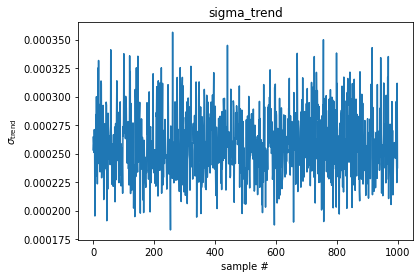

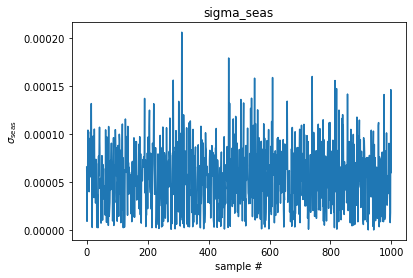

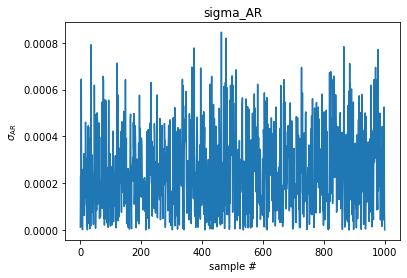

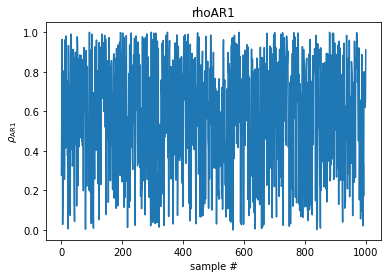

In [35]:
# Do trace plots of the MCMC chains of the hyper-parameters

plt.plot(sigma_trend)
plt.title('sigma_trend')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{trend}$')
plt.show()

plt.plot(sigma_seas)
plt.title('sigma_seas')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{seas}$')
plt.show()

plt.plot(sigma_AR)
plt.title('sigma_AR')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{AR}$')
plt.show()

plt.plot(rhoAR1)
plt.title('rhoAR1')
plt.xlabel('sample #')
plt.ylabel(r'$\rho_\mathrm{AR1}$')
plt.show()